In [ ]:
!git clone https://github.com/Pu-Zeng/696-Milestone.git

Cloning into '696-Milestone'...
remote: Enumerating objects: 2992, done.
remote: Counting objects: 100% (2992/2992), done.
remote: Compressing objects: 100% (2517/2517), done.
remote: Total 2992 (delta 32), reused 2987 (delta 27), pack-reused 0
Receiving objects: 100% (2992/2992), 31.95 MiB | 20.69 MiB/s, done.
Resolving deltas: 100% (32/32), done.


It seems after installing topicwizard, we should restart the Colab to work properly.

This code restart the notebook automatically after installing the library.

Please run this cell again after restart

In [ ]:
# It seems after installing topicwizard, we should restart the Colab to work properly.
# This code restart the notebook automatically after installing the library
# Please run this cell again after restart
try:
  from sklearn.feature_extraction.text import TfidfVectorizer
  from sklearn.decomposition import NMF
  from sklearn.feature_extraction.text import CountVectorizer
  import topicwizard
  from topicwizard.pipeline import make_topic_pipeline
  from sklearn.decomposition import LatentDirichletAllocation
  import pandas as pd
  from tqdm import tqdm
  import numpy as np
  from langdetect import detect
  import gensim.downloader as api
  from itertools import combinations
except:
  !pip install langdetect
  !pip install topic-wizard
  !pip install --upgrade pip
  import os
  os.kill(os.getpid(), 9)

# Data Preprocessing

In [ ]:
with open('/content/696-Milestone/Toy_Dataset/Lyrics/mxm_dataset_train_cleaned_toy.txt', encoding='utf8') as f:
    lines = f.readlines()

lines = lines[17:] #The first 17th lines are some introduction

words = lines[0][1:].split(',') #The 18th line is the word vocabulary

In [ ]:
# Turn word-of-bag into tf-idf
res = []
for line in tqdm(lines[1:]):
    embedding = np.zeros(50)
    count = 0
    words_ = []
    for word in line.split(',')[2:]:
        k,v = (int(x) for x in word.split(':'))
        music_ID = line.split(',')[0]
        words_+=([words[k-1]]*v)
    res.append(' '.join(words_))

100%|██████████| 982/982 [00:00<00:00, 1396.61it/s]


In [ ]:
from langdetect import detect
res1 = []
for line in tqdm(res):
    try:
        if (len(line)>150) & (detect(line)=='en'):
            res1.append(line)
    except:
        pass

100%|██████████| 982/982 [00:08<00:00, 121.15it/s]


In [ ]:
with open('/content/696-Milestone/Toy_Dataset/Lyrics/mxm_dataset_test_toy.txt', encoding='utf8') as f:
    lines = f.readlines()

lines = lines[17:] #The first 17th lines are some introduction

words = lines[0][1:].split(',') #The 18th line is the word vocabulary

In [ ]:
# Turn word-of-bag into tf-idf
res_test = []
for line in tqdm(lines[1:]):
    embedding = np.zeros(50)
    count = 0
    words_ = []
    for word in line.split(',')[2:]:
        k,v = (int(x) for x in word.split(':'))
        music_ID = line.split(',')[0]
        words_+=([words[k-1]]*v)
    res_test.append(' '.join(words_))

100%|██████████| 982/982 [00:00<00:00, 2191.28it/s]


In [ ]:
res1_test = []
for line in tqdm(res_test):
    try:
        if (len(line)>150) & (detect(line)=='en'):
            res1_test.append(line)
    except:
        pass

100%|██████████| 982/982 [00:08<00:00, 112.24it/s]


# Find the optimal number of clusters + Evaluation

In [ ]:
glove_model = api.load("glove-wiki-gigaword-50")
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            try:
                pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
            except:
                pass
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=10, stop_words="english")
tf_idf_vec = vectorizer.fit_transform(res1)
tf_idf_vec_test = vectorizer.transform(res1_test)
terms =  list(vectorizer.get_feature_names_out())
score_res = []
for n in tqdm(list(range(5,30))):
    nmf = NMF(n_components=n)
    # pipeline = make_topic_pipeline(vectorizer, nmf)
    nmf.fit(tf_idf_vec)
    H = nmf.components_
    term_rankings=[]
    for topic_index in range(n):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    nmf_score = calculate_coherence(glove_model, term_rankings)

    lda = LatentDirichletAllocation(n_components=n,random_state=0,n_jobs=-1)
    lda.fit(tf_idf_vec)
    H = lda.components_
    term_rankings=[]
    for topic_index in range(n):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    lda_score = calculate_coherence(glove_model, term_rankings)
    perplexity = lda.perplexity(tf_idf_vec)
    score_res.append([n, nmf_score, lda_score, perplexity])
score_df = pd.DataFrame(score_res, columns = ['num_clusters','nmf_coherence', 'lda_coherence', 'lda_perplexity'])

 24%|██▍       | 6/25 [00:17<00:59,  3.16s/it]/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 52%|█████▏    | 13/25 [00:40<00:30,  2.58s/it]/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 56%|█████▌    | 14/25 [00:43<00:31,  2.87s/it]/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 60%|██████    | 15/25 [00:45<00:25,  2.55s/it]/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 68%|██████▊   | 17/25 [00:49<00:18,  2.26s/it]/u

In [ ]:
score_df = pd.DataFrame(score_res, columns = ['num_clusters','nmf_coherence', 'lda_coherence', 'lda_perplexity'])
score_df

,num_clusters,nmf_coherence,lda_coherence,lda_perplexity
0,5,0.555541,0.365566,1762.455459
1,6,0.556596,0.334853,2117.007504
2,7,0.527592,0.292282,2221.164028
3,8,0.496875,0.313889,2493.427973
4,9,0.497735,0.350301,2217.376549
5,10,0.504608,0.317924,2644.829622
6,11,0.497962,0.274947,2787.876093
7,12,0.476115,0.333921,3863.721002
8,13,0.494047,0.343976,4465.674345
9,14,0.463604,0.327591,4383.571437


Text(0, 0.5, 'TC-W2V')

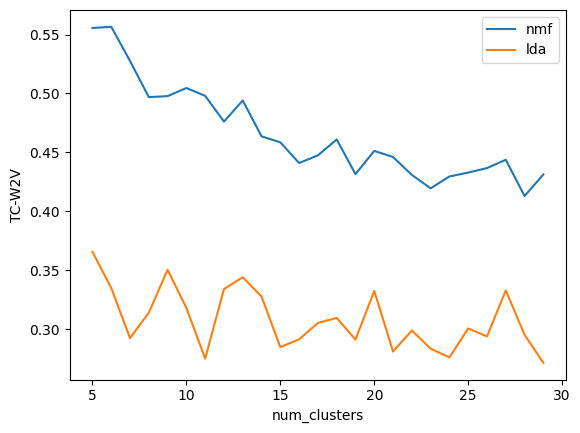

In [ ]:
import matplotlib.pyplot as plt
plt.plot(score_df['num_clusters'], score_df['nmf_coherence'], label = 'nmf')
plt.plot(score_df['num_clusters'], score_df['lda_coherence'], label = 'lda')
plt.legend()
plt.xlabel('num_clusters')
plt.ylabel('TC-W2V')

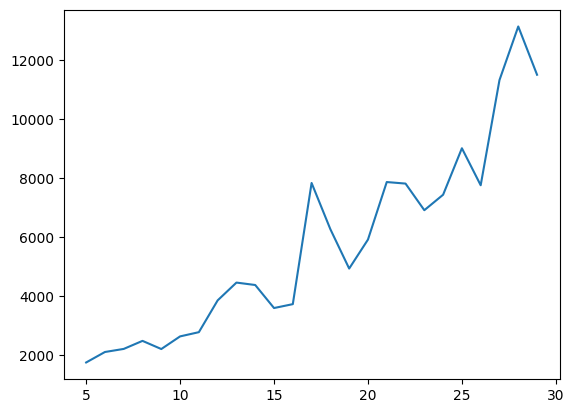

In [ ]:
plt.plot(score_df['num_clusters'], score_df['lda_perplexity'], label = 'nmf')

# NMF

In [ ]:
# Setting up topic modelling pipeline
vectorizer = TfidfVectorizer(max_df=0.8, min_df=10, stop_words="english")
# NMF topic model with 20 topics
nmf = NMF(n_components=6)
pipeline = make_topic_pipeline(vectorizer, nmf)
pipeline.fit(res1)
# topicwizard.visualize(res1, pipeline=pipeline,exclude_pages=["documents"])

TopicPipeline(steps=[('tfidfvectorizer',
                      TfidfVectorizer(max_df=0.8, min_df=10,
                                      stop_words='english')),
                     ('nmf', NMF(n_components=6))])

In [ ]:
# Fitting pipeline
pipeline = make_topic_pipeline(vectorizer, nmf)
pipeline.fit(res1)
topicwizard.visualize(res1, pipeline=pipeline,exclude_pages=["documents"])

Preprocessing
Dash is running on http://127.0.0.1:8050/



INFO:topicwizard.app:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app 'topicwizard.app'
 * Debug mode: off
Open in browser:


<IPython.core.display.Javascript object>

<Thread(Thread-11 (_run_silent), started 138376381462080)>

# LDA

In [ ]:
lda = LatentDirichletAllocation(n_components=8,random_state=0,n_jobs=-1)
# vectorizer = CountVectorizer(max_df=0.8, min_df=10, stop_words="english")
vectorizer = TfidfVectorizer(max_df=0.8, min_df=10, stop_words="english")
pipeline_lda = make_topic_pipeline(vectorizer, lda)
pipeline_lda.fit(res1)

TopicPipeline(steps=[('tfidfvectorizer',
                      TfidfVectorizer(max_df=0.8, min_df=10,
                                      stop_words='english')),
                     ('latentdirichletallocation',
                      LatentDirichletAllocation(n_components=8, n_jobs=-1,
                                                random_state=0))])

In [ ]:
topicwizard.visualize(res1, pipeline=pipeline_lda,exclude_pages=["documents"])

Preprocessing
Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/



INFO:topicwizard.app:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app 'topicwizard.app'
 * Debug mode: off


Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.


Open in browser:


<IPython.core.display.Javascript object>

<Thread(Thread-12 (_run_silent), stopped 138376362583616)>

# Sensitivity

In [ ]:
np.linspace(0.05, 0.3, 6)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ])

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=10, stop_words="english")
tf_idf_vec = vectorizer.fit_transform(res1)
# tf_idf_vec_test = vectorizer.fit_transform(res1_test)
terms =  list(vectorizer.get_feature_names_out())
score_res = []
for i in tqdm(np.linspace(0.05, 0.2, 6)):
    for j in np.linspace(0.05, 0.3, 6):
        lda = LatentDirichletAllocation(n_components=8,random_state=0,n_jobs=-1,doc_topic_prior=i,topic_word_prior=j)
        lda.fit(tf_idf_vec)
        H = lda.components_
        term_rankings=[]
        for topic_index in range(8):
            term_rankings.append(get_descriptor(terms, H, topic_index, 10))
        lda_score = calculate_coherence(glove_model, term_rankings)
        perplexity = lda.perplexity(tf_idf_vec_test)
        score_res.append([i, j, lda_score, perplexity, lda])


100%|██████████| 6/6 [01:05<00:00, 10.99s/it]


In [ ]:
sensitivity_score = pd.DataFrame([x[:-1] for x in score_res], columns = ['doc_topic_prior', 'topic_word_prior', 'coherence','perplexity'])

In [ ]:
sensitivity_score.pivot_table(index='doc_topic_prior', columns = 'topic_word_prior', values = 'coherence')

topic_word_prior,0.05,0.10,0.15,0.20,0.25,0.30
doc_topic_prior,,,,,,
0.05,0.289506,0.370309,0.391281,0.309305,0.343672,0.341012
0.08,0.308341,0.332912,0.377480,0.303385,0.328733,0.318896
0.11,0.279906,0.287513,0.328515,0.366161,0.340095,0.411415
0.14,0.302746,0.284253,0.295765,0.288304,0.352022,0.346862
0.17,0.266318,0.341497,0.357521,0.329331,0.387424,0.395267
0.20,0.325906,0.314518,0.375208,0.334384,0.371186,0.366287


In [ ]:
sensitivity_score.pivot_table(index='doc_topic_prior', columns = 'topic_word_prior', values = 'perplexity')

topic_word_prior,0.05,0.10,0.15,0.20,0.25,0.30
doc_topic_prior,,,,,,
0.05,2450.891222,1850.168177,1719.857913,1639.832424,1589.142488,1551.644261
0.08,2525.274831,1994.539785,1829.859097,1743.781089,1691.899268,1651.188729
0.11,3172.309424,2395.621826,1995.052716,1929.941152,1886.727379,1952.068551
0.14,3296.453486,2636.313220,2174.400606,2119.930915,1992.115989,1905.014122
0.17,3735.241702,3189.004654,2669.139657,2453.935534,2434.402351,2347.829980
0.20,4283.624556,3528.031960,3034.642638,2644.913563,2560.609821,2385.511394
